In [2]:
import os
import numpy as np
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import shutil

In [3]:
''' SET THE DEVICE '''
device = 'mps' if torch.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device
print(f"Using device: {device}")

Using device: mps


In [4]:
import kagglehub
''' UNCOMMENT THE FOLLOWING LINES TO DOWNLOAD DATASET '''
#path = kagglehub.dataset_download('mostafaabla/garbage-classification')
#print('path to dataset files', path)

/Users/kazikgarstecki/Desktop/Y2S2/as_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


' UNCOMMENT THE FOLLOWING LINES TO DOWNLOAD DATASET '

In [5]:
dir_path = os.path.join(os.getcwd(), 'data/garbage_classification/')

print('All catgories of garbage classification dataset')
print('----------------------------------------------------')
for file in os.listdir(dir_path):
    print(file)

All catgories of garbage classification dataset
----------------------------------------------------
paper
green-glass
metal
cardboard
trash
biological
white-glass
brown-glass
plastic


In [6]:
data_dict = {directory_name: [] for directory_name in os.listdir(dir_path)}

data_path = Path('data/garbage_classification/')

categories_to_include = [
    'cardboard',
    'green-glass',
    'white-glass',
    'brown-glass',
    'metal',
    'paper',
    'plastic',
    'trash',
    'biological'
]

for category_name in data_dict.keys():
    if category_name in categories_to_include:
        image_dir = data_path / category_name
        for image in tqdm(os.listdir(image_dir)):
            img = Image.open(image_dir / image)
            img = img.resize((512, 512))
            data_dict[category_name].append(img)

100%|██████████| 865/865 [00:04<00:00, 187.33it/s]


In [7]:
for category_name in os.listdir(Path('data/garbage_classification/')):
    if category_name not in categories_to_include:
        shutil.rmtree(data_path / category_name)
        print(f"Removed {category_name} directory and its contents.")
    else:
        print(len(os.listdir(data_path / category_name)), 'images in', category_name, 'directory')

1050 images in paper directory
629 images in green-glass directory
769 images in metal directory
891 images in cardboard directory
697 images in trash directory
985 images in biological directory
775 images in white-glass directory
607 images in brown-glass directory
865 images in plastic directory


In [9]:
train_test_dataset = Path('train_test_dataset/garbage_classification')
if not os.path.exists(train_test_dataset):
    os.makedirs(train_test_dataset)
    for train_test in ['train', 'test']:
        if not os.path.exists(train_test_dataset / train_test):
            os.makedirs(train_test_dataset / train_test)

In [73]:
for category_name in tqdm(categories_to_include):
    image_dir = data_path / category_name
    all_images = os.listdir(image_dir)
    img = Image.open(image_dir / all_images[0])
    train_images = random.sample(all_images, int(len(all_images) * 0.8))
    print('Number of images in category:', category_name, len(all_images))
    print(len(train_images), 'images in train set')
    test_images = list(set(all_images) - set(train_images))
    print(len(test_images), 'images in test set')
    for image in train_images:
        path_to_move = train_test_dataset/ 'train' / category_name
        if not os.path.exists(path_to_move):
            os.makedirs(path_to_move)
        img_path = image_dir / image
        shutil.copy(img_path, path_to_move)
    for image in test_images:
        path_to_move = train_test_dataset / 'test' / category_name
        if not os.path.exists(path_to_move):
            os.makedirs(path_to_move)
        img_path = image_dir / image
        shutil.copy(img_path, path_to_move)

  0%|          | 0/9 [00:00<?, ?it/s]

Number of images in category: cardboard 891
712 images in train set
179 images in test set


 11%|█         | 1/9 [00:02<00:20,  2.51s/it]

Number of images in category: green-glass 629
503 images in train set
126 images in test set


 22%|██▏       | 2/9 [00:04<00:15,  2.15s/it]

Number of images in category: white-glass 775
620 images in train set
155 images in test set


 33%|███▎      | 3/9 [00:06<00:11,  1.94s/it]

Number of images in category: brown-glass 607
485 images in train set
122 images in test set


 44%|████▍     | 4/9 [00:07<00:09,  1.91s/it]

Number of images in category: metal 769
615 images in train set
154 images in test set


 56%|█████▌    | 5/9 [00:08<00:05,  1.38s/it]

Number of images in category: paper 1050
840 images in train set
210 images in test set


 67%|██████▋   | 6/9 [00:08<00:03,  1.09s/it]

Number of images in category: plastic 865
692 images in train set
173 images in test set


 78%|███████▊  | 7/9 [00:10<00:02,  1.09s/it]

Number of images in category: trash 697
557 images in train set
140 images in test set


 89%|████████▉ | 8/9 [00:10<00:01,  1.02s/it]

Number of images in category: biological 985
788 images in train set
197 images in test set


100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


In [10]:
for directory_name in os.listdir(Path('data/garbage_classification')):
    print(directory_name)
    print(len(os.listdir(train_test_dataset / 'train' / directory_name)))
    print(len(os.listdir(train_test_dataset / 'test' / directory_name)))

paper
840
210
green-glass
503
126
metal
615
154
cardboard
712
179
trash
557
140
biological
788
197
white-glass
620
155
brown-glass
485
122
plastic
692
173


In [17]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import pytorch_lightning as pl

In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
}

In [19]:
train_dataset = datasets.ImageFolder(root=Path('train_test_dataset/garbage_classification/train'),
                                     transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=Path('train_test_dataset/garbage_classification/test'),
                                    transform=data_transforms['test'])
print(len(train_dataset), len(test_dataset))

5812 1456


In [20]:
LABELS = train_dataset.classes
print(train_dataset.class_to_idx)

{'biological': 0, 'brown-glass': 1, 'cardboard': 2, 'green-glass': 3, 'metal': 4, 'paper': 5, 'plastic': 6, 'trash': 7, 'white-glass': 8}


In [21]:
torch.manual_seed(42)
np.random.seed(42)
indices = np.random.permutation(len(train_dataset)).tolist()

In [22]:
def show_image(image, label):
    plt.title(f'label: {label}, {LABELS[label]}\n')
    plt.imshow(transforms.ToPILImage()(image).convert('RGB'))

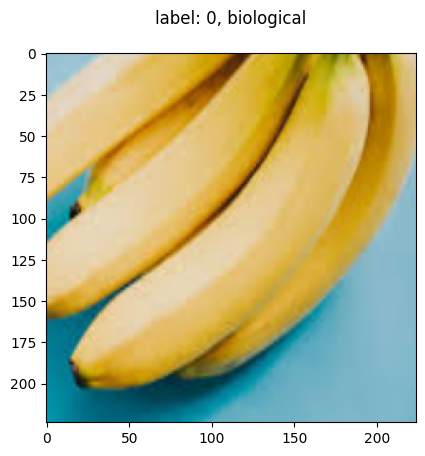

In [23]:
image, label = train_dataset[0][0], train_dataset[0][1]
show_image(image, label)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]) tensor(7)


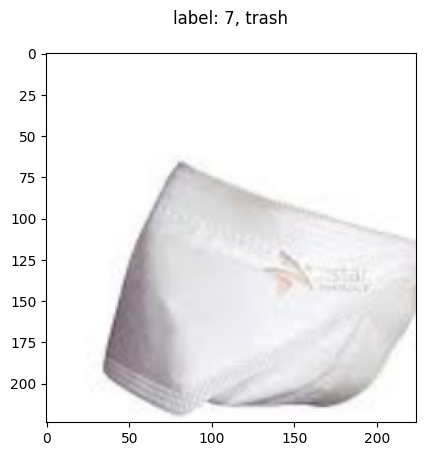

In [25]:
inputs, labels = next(iter(train_loader))
print(inputs[0], labels[0])
show_image(inputs[0], labels[0])

In [28]:
from pytorch_lightning import Callback

class MetricMonitor(Callback):
    def __init__(self):
        self.history = []
        self.epoch = 0

    def on_train_epoch_end(self, trainer, pl_module):
        elogs = {item: float(value) for (item, value) in trainer.logged_metrics.items()}
        print(f"Epoch [{self.epoch}] train_loss: {elogs['train_loss_epoch']:.3f}, train_acc: {elogs['train_acc']:.3f}")
        self.epoch += 1
        self.history.append(elogs)

In [31]:
from torch import nn

In [32]:
import torchmetrics
import torch.nn.functional as F
import torchvision.models as models

class LigResNet(pl.LightningModule):
    def __init__(self, lr, num_class, *args, **kwargs):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_class)
        
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_class)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_class)
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        
        self.train_acc(torch.argmax(logits, dim=1), y)
        
        self.log('train_loss', loss.item(), on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self.model(X)
        loss = F.cross_entropy(logits, y)
        
        self.test_acc(torch.argmax(logits, dim=1), y)
        
        self.log('test_loss', loss.item(), on_epoch=True)
        self.log('test_acc', self.test_acc, on_epoch=True)
    
    def predict_step(self, batch, batch_idx):
        X, y = batch
        preds = self.model(X)
        return preds

In [33]:
num_class = len(LABELS)
model = LigResNet(lr=0.00005, num_class=num_class)
model.model.fc
model = model.to(device)

/Users/kazikgarstecki/Desktop/Y2S2/as_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kazikgarstecki/Desktop/Y2S2/as_project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [111]:
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

mm = MetricMonitor()
csv_log = CSVLogger('logs', name='garbage_classification')

trainer = pl.Trainer(
    accelerator='mps',
    limit_train_batches=100,
    max_epochs=20,
    devices=1,
    callbacks=[mm],
    default_root_dir='./logs/resnet'
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [204]:
trainer.fit(model, train_loader, test_loader)

/Users/kazikgarstecki/Desktop/Y2S2/as_project/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 23.5 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.106    Total estimated model params size (MB)
153       Modules in train mode
0         Modules in eval mode


/Users/kazikgarstecki/Desktop/Y2S2/as_project/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 19: 100%|██████████| 100/100 [01:44<00:00,  0.96it/s, v_num=2, train_acc=0.943]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 100/100 [01:44<00:00,  0.95it/s, v_num=2, train_acc=0.943]


In [112]:
trainer.test(model, test_loader, ckpt_path='best')

ValueError: `.test(ckpt_path="best")` is set but `ModelCheckpoint` is not configured to save the best model.

In [54]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

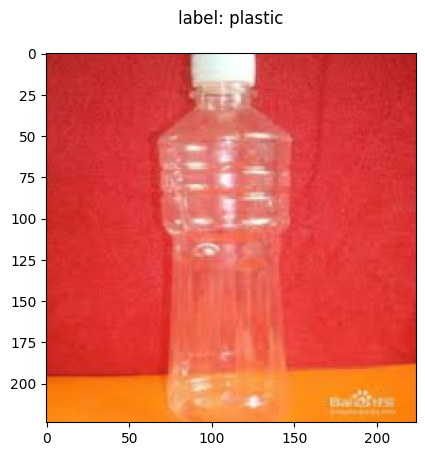

In [119]:
for directory_name in os.listdir(Path('train_test_dataset/garbage_classification/test')):
    for image in os.listdir(Path('train_test_dataset/garbage_classification/test') / directory_name):
        img = Image.open(Path('train_test_dataset/garbage_classification/test') / directory_name / image)
        input_tensor = preprocess(img)
        plt.title(f'label: {directory_name}\n')
        plt.imshow(transforms.ToPILImage()(input_tensor).convert('RGB'))
        break

In [35]:
checkpoint = torch.load('/Users/kazikgarstecki/Desktop/Y2S2/as_project/logs/resnet/lightning_logs/version_2/checkpoints/epoch=19-step=2000.ckpt', map_location=torch.device('cpu'))  # Or 'cuda' if you're using GPU

In [117]:
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

In [120]:
input_tensor.shape
input_tensor = input_tensor.unsqueeze(0)
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [121]:
def inference(model, input_tensor):
    model.eval()
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        return predicted.item()

In [122]:
for directory_name in os.listdir(Path('train_test_dataset/garbage_classification/test')):
    print(f'CORRECT CLASS: {directory_name}')
    for image in os.listdir(Path('train_test_dataset/garbage_classification/test') / directory_name):
        img = Image.open(Path('train_test_dataset/garbage_classification/test') / directory_name / image)
        input_tensor = preprocess(img)
        input_tensor = input_tensor.unsqueeze(0)
        print('PREDICTED CLASS:', LABELS[inference(model, input_tensor)])
        break

CORRECT CLASS: paper
PREDICTED CLASS: paper
CORRECT CLASS: green-glass
PREDICTED CLASS: green-glass
CORRECT CLASS: metal
PREDICTED CLASS: metal
CORRECT CLASS: cardboard
PREDICTED CLASS: cardboard
CORRECT CLASS: trash
PREDICTED CLASS: trash
CORRECT CLASS: biological
PREDICTED CLASS: biological
CORRECT CLASS: white-glass
PREDICTED CLASS: white-glass
CORRECT CLASS: brown-glass
PREDICTED CLASS: brown-glass
CORRECT CLASS: plastic
PREDICTED CLASS: plastic


In [123]:
accuracy_dict = {directory_name: 0 for directory_name in os.listdir(Path('train_test_dataset/garbage_classification/test'))}
for directory_name in os.listdir(Path('train_test_dataset/garbage_classification/test')):
    accuracy = 0
    print(directory_name)
    images_from_category = random.sample(os.listdir(Path('train_test_dataset/garbage_classification/test') / directory_name), 100)
    for img in images_from_category:
        image = Image.open(Path('train_test_dataset/garbage_classification/test') / directory_name / img)
        input_tensor = preprocess(image)
        input_tensor = input_tensor.unsqueeze(0)
        if input_tensor.shape != (1, 3, 224, 224):
            input_tensor = input_tensor.repeat(1, 3, 1, 1)
        with torch.no_grad():
            model.eval()
            input_tensor = input_tensor.to(device)
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            if LABELS[predicted.item()] == directory_name:
                accuracy += 1
    accuracy_dict[directory_name] = accuracy / 100

paper
green-glass
metal
cardboard
trash
biological
white-glass
brown-glass
plastic


In [124]:
print(accuracy_dict)

{'paper': 0.97, 'green-glass': 0.97, 'metal': 0.96, 'cardboard': 0.98, 'trash': 0.99, 'biological': 0.96, 'white-glass': 0.97, 'brown-glass': 0.98, 'plastic': 0.93}


In [126]:
print(f'{sum(accuracy_dict.values()) / len(accuracy_dict):.2f}')

0.97
